![MLU Logo](../../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Computer Vision - Lecture 1</a>


## Convolutional Neural Networks with PyTorch

In this notebook, we strengthen the fundamental understanding of Convolutional Neural Network (CNN) by using built-in CNN architectures in [PyTorch](https://pytorch.org/docs/stable/index.html) to train a multiclass classification model on a real-world dataset.

1. <a href="#1">A Toy Example</a>
    * <a href="#11">Convolution 2D</a> 
    * <a href="#12">Padding and Stride</a>
    * <a href="#13">Computing the Shape</a>
    * <a href="#14">Pooling</a>
    
    
2. <a href="#2">A Real-world Example - MINC</a>
    * <a href="#21">Loading the datasets</a>
    * <a href="#22">Designing the Network Architectures</a>

In [1]:
! pip install -q -r ../../requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


Notice that, if you are running on GPU, please ensure you are:
1. using library `torch` >= 1.6.0, and
1. using library `d2l` >= 0.15.0

by running the following updating command.

In [2]:
! pip list | egrep torch

torch                              1.9.0
torchvision                        0.10.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
! pip list | egrep d2l

d2l                                0.17.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


After the sanity check, let's import the packages for this notebook:

In [4]:
import os
from d2l import torch as d2l
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.nn import BCELoss
from sklearn.metrics import accuracy_score

## 1. <a name="1">A Toy Example</a>
(<a href="#0">Go to top</a>)

### 1.1 <a name="11">Convolution 2D</a>
(<a href="#0">Go to top</a>)

Firstly, let's use the built-in CNN classes in PyTorch with a toy example. PyTorch has a variety of convolutional layers such as 


```python
nn.Conv1d()
nn.Conv2d()
nn.Conv3d()
```

and more operators [here](https://pytorch.org/docs/stable/nn.html#convolution-layers). 


### 1.2 <a name="12">Padding and Stride</a>
(<a href="#0">Go to top</a>)

In the built-in classes, we can also add padding and stride. Recall that:

"padding" adds rows/columns around the input, 

![Padding.](https://d2l.ai/_images/conv-pad.svg)


while "stride" refers to the number of “unit” the kernel shifted per slide over rows/columns.

![Stride.](https://d2l.ai/_images/conv-stride.svg)



### 1.3 <a name="13">Computing the Shape</a>
(<a href="#0">Go to top</a>)


Let's experiment an example with input shape of (3, 3), with a kernel size of 2, padding size of 1 on both sides and stride size of (2, 3). The output shape of the `Conv2d()` should be:

\begin{align}
\text{ Output shape} & = \lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor \\
 & = \lfloor(3 - 2 + 2*1 + 2) / 2\rfloor \times \lfloor(3 - 2 + 2*1 + 3) / 3\rfloor \\
 & = (2, 2)
\end{align}

Let's validate in code! To check the output of the convolution layers, we define the `comp_conv2d` function as forward propogation.

In [5]:
def comp_conv2d(conv2d, X):
    # Add batch and channel dimension.
    X = X.reshape((1, 1) + X.shape) # after reshape, shape=(1,1,3,3)
    Y = conv2d(X)
    # Exclude the first two dimensions
    return Y.reshape(Y.shape[2:])

Now we can verify the output shape of the Conv2D layer.

In [6]:
X = torch.rand(size=(3, 3))
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, padding=1, stride=(2,3))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

### 1.4 <a name="14">Pooling</a>
(<a href="#0">Go to top</a>)

Recall max pooling returns the maximal value in the pooling window, while average pooling summizes the means.

![Pooling.](https://d2l.ai/_images/pooling.svg)


We can also import built-in pooling layer from PyTorch with Padding and Stride, such as `MaxPool2d()` or `AvgPool1d()`. See full list of built-in pooling architectures [here](https://pytorch.org/docs/stable/nn.html#pooling-layers).

In [7]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
print(X)
pool2d = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 2. <a name="2">A Real-world Example - MINC</a>
(<a href="#0">Go to top</a>)

[MINC](http://opensurfaces.cs.cornell.edu/publications/minc/) is short for Materials in Context Database, provided by Cornell. __We will use a subset of this dataset with the following classes: brick, carpet, food, mirror, sky, water.__ It is well labeled and has a moderate size thus is perfect to be our example.


![MINC 2500 Examples.](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/MINC-2500.png)


### 2.1 <a name="21">Loading the datasets</a>
(<a href="#0">Go to top</a>)

First, let's  define the paths for train, validation and test dataset. 

In [8]:
path = '../../data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

It is a good practice to visualize what does the dataset look like! Let's define the `show_images` function and see some sample images in MINC.

In [9]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1,2,0).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

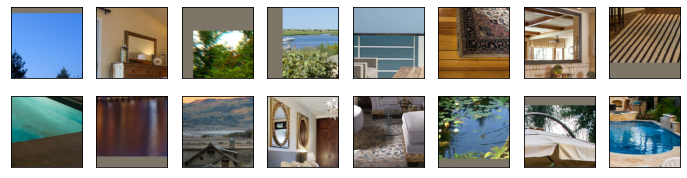

In [10]:
train_dataset = torchvision.datasets.ImageFolder(test_path, transform=transforms.ToTensor())
test_sample = torch.utils.data.DataLoader(train_dataset, batch_size=2*8, shuffle=True)

for data, label in test_sample:
    show_images(data, 2, 8);
    break

To load the dataset properly, we need to massage the image data a bit by some `transfom` functions. First, we load the image data and resize it to the given size (224,224). Next, we convert the image tensor of shape (C x H x W) in the range [0, 255] to a float32 torch tensor of shape (C x H x W) in the range (0, 1) using the `ToTensor` class. Last, we normalize an tensor of shape (C x H x W) with its mean and standard deviation by `Normalize`.

In [11]:
transformation = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0), std=(1,1,1))
])

Now apply the predefined transform functions and load the train, validation and test sets.

In practice, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. To make our life easier when reading from the datasets, we use a `DataLoader` of PyTorch, which reads a minibatch of data with size `batch_size` each time.

In [12]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transformation),
    batch_size=batch_size, shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(val_path, transform=transformation),
    batch_size=batch_size, shuffle=False)

test_data = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transformation),
    batch_size=batch_size, shuffle=False)

### 2.2 <a name="22">Designing the Network Architectures</a>
(<a href="#0">Go to top</a>)

Now it's the time to design a Convolutional neural network! First, let's initailize a `Sequential` block. In PyTorch, `Sequential` defines a container for several layers that will be chained together. Given input data, a `Sequential` passes it through the first layer, in turn passing the output as the second layer’s input and so forth.

We will build a neural netword with a 2D convolutional layer `Conv2D`, following by a 2D maxpooling layer `MaxPool2D`, a fully connected (or `Dense`) layer, and a final output `Dense` layer with output classes 23.

In [13]:
out_classes = 6

net = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # The Flatten layer collapses all axis, except the first one, into one axis.
    nn.Flatten(),
    nn.Linear(110*110*20, 128),
    nn.ReLU(),
    nn.Linear(128, out_classes))

Our network is almost ready to be trained! One last thing before the training is to set up the hyperparameters, such training device `device` (GPU or CPU), the number of epochs to train, the learning rate of optimization algorithms. Besides, we specify the loss function. Since this problem is a multiclass classification task, we will use `CrossEntropyLoss` as our loss funciton.

In [14]:
device = d2l.try_gpu() # Set this to CPU or GPU depending on your training instance

epochs = 15
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()

To infer the neural network "how to optimize its weights", we instantiate the `optim.<Optimizer>`, which defines the parameters to optimize over (obtainable from our net via net.parameters()) and the hyperparameters required by our optimization algorithm.

In [15]:
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

Now it's the training time! Starting with the outer loop, we will have 15 epochs (15 full pass through our dataset).

In [16]:
for epoch in range(epochs):
    net = net.to(device)
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    for i, (data, label) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        loss = criterion(output, label)
        loss.backward()
        train_acc += (output.argmax(axis=1) == label.float()).float().mean()
        train_loss += loss
        optimizer.step()
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    for i, (data, label) in enumerate(validation_loader):
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        valid_acc += (output.argmax(axis=1) == label.float()).float().mean()
        val_loss += criterion(output, label)
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch+1, train_loss.detach().cpu().numpy(), train_acc.detach().cpu().numpy(),
        val_loss.detach().cpu().numpy(), valid_acc.detach().cpu().numpy()))

Epoch 1: train loss 1.647, train acc 0.299, val loss 1.428, val acc 0.401
Epoch 2: train loss 1.436, train acc 0.400, val loss 1.366, val acc 0.438
Epoch 3: train loss 1.321, train acc 0.480, val loss 1.277, val acc 0.484
Epoch 4: train loss 1.217, train acc 0.517, val loss 1.189, val acc 0.562
Epoch 5: train loss 1.118, train acc 0.575, val loss 1.338, val acc 0.453
Epoch 6: train loss 1.039, train acc 0.615, val loss 1.128, val acc 0.557
Epoch 7: train loss 0.968, train acc 0.635, val loss 1.125, val acc 0.578
Epoch 8: train loss 0.919, train acc 0.661, val loss 1.135, val acc 0.552
Epoch 9: train loss 0.853, train acc 0.695, val loss 1.111, val acc 0.568
Epoch 10: train loss 0.798, train acc 0.717, val loss 1.056, val acc 0.578
Epoch 11: train loss 0.695, train acc 0.760, val loss 1.138, val acc 0.583
Epoch 12: train loss 0.635, train acc 0.782, val loss 1.346, val acc 0.589
Epoch 13: train loss 0.593, train acc 0.802, val loss 1.178, val acc 0.573
Epoch 14: train loss 0.495, train 

As you may notice that the training loss and accurcay keep improving, while the validation loss and accuracy are fluctuated. This is a signal of overfitting. As a result, in the following sessions, we will show you more advanced neural network architectures (such as AlexNet and ResNet) to stablize the training!